In [2]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import torch
from tqdm import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [4]:
BATCH_SIZE = 8

trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=8)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=8)

classes = {i:name for i, name in enumerate(trainset.classes)}
classes

Files already downloaded and verified
Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

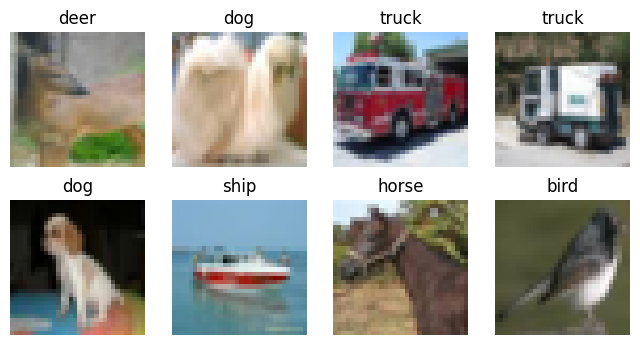

In [6]:
imgs, labels = next(iter(trainloader))
show_imgs(imgs, labels)

### Model

In [7]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim: int, n_classes: int ):
#         super(Generator, self).__init__()
#         self.latent_dim = latent_dim
#         self.n_classes = n_classes
#         self.embeddings = nn.Embedding(num_embeddings=n_classes,
#                                        embedding_dim=latent_dim)
        
#         self.model = nn.Sequential(
#             nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
#             # ConvBlock2 (4x4)
#             nn.ConvTranspose2d(in_channels=latent_dim, 
#                                out_channels=256,
#                                kernel_size=4, 
#                                stride=1, bias=False),
#             nn.BatchNorm2d(num_features=256, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # ConvBlock3 (8x8)
#             nn.ConvTranspose2d(in_channels=256, 
#                                out_channels=128,
#                                kernel_size=4, 
#                                stride=2, 
#                                padding=1, bias=False),
#             nn.BatchNorm2d(num_features=128, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # ConvBlock4 (16x16)
#             nn.ConvTranspose2d(in_channels=128, 
#                                out_channels=64,
#                                kernel_size=4, 
#                                stride=2, 
#                                padding=1, bias=False), 
#             nn.BatchNorm2d(num_features=64, momentum=0.9),
#             nn.LeakyReLU(negative_slope=0.15),
#             # Final Conv Transpose (32x32)
#             nn.ConvTranspose2d(in_channels=64, 
#                                out_channels=3,
#                                kernel_size=4,
#                                stride=2, 
#                                padding=1, bias=False))
    
#     def forward(self, labels):
#         cls_embds = self.embeddings(labels)
#         eps = torch.randn_like(cls_embds)
#         return self.model(cls_embds + eps)

class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.UpsamplingBilinear2d(size=(4,4)),
            nn.Conv2d(in_channels=latent_dim,
                      out_channels=256,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),            
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.UpsamplingBilinear2d(size=(8,8)),
            nn.Conv2d(in_channels=256,
                      out_channels=128,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.UpsamplingBilinear2d(size=(16,16)),
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.UpsamplingBilinear2d(size=(32,32)),
            nn.Conv2d(in_channels=64,
                      out_channels=3,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.Sigmoid())
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, imgs, labels):
        embds = self.embeddings(labels).view(input.shape)
        concat = torch.cat((imgs, embds), dim=1)
        return self.model(concat)

In [47]:
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
class CGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)      
        return out.detach()
    
    def compile(self, g_optimizer, g_loss,
                      d_optimizer, d_loss):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss 
        self.d_loss = d_loss
    
    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        alpha = torch.randn((*real_imgs.shape[:2], 1, 1))
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.discriminator(interpolation, labels)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(labels.shape[0], -1)
        grad_norm = gradients.norm(2, 1)
        return ((grad_norm-1)**2).mean()

### Training Implementation Scheme

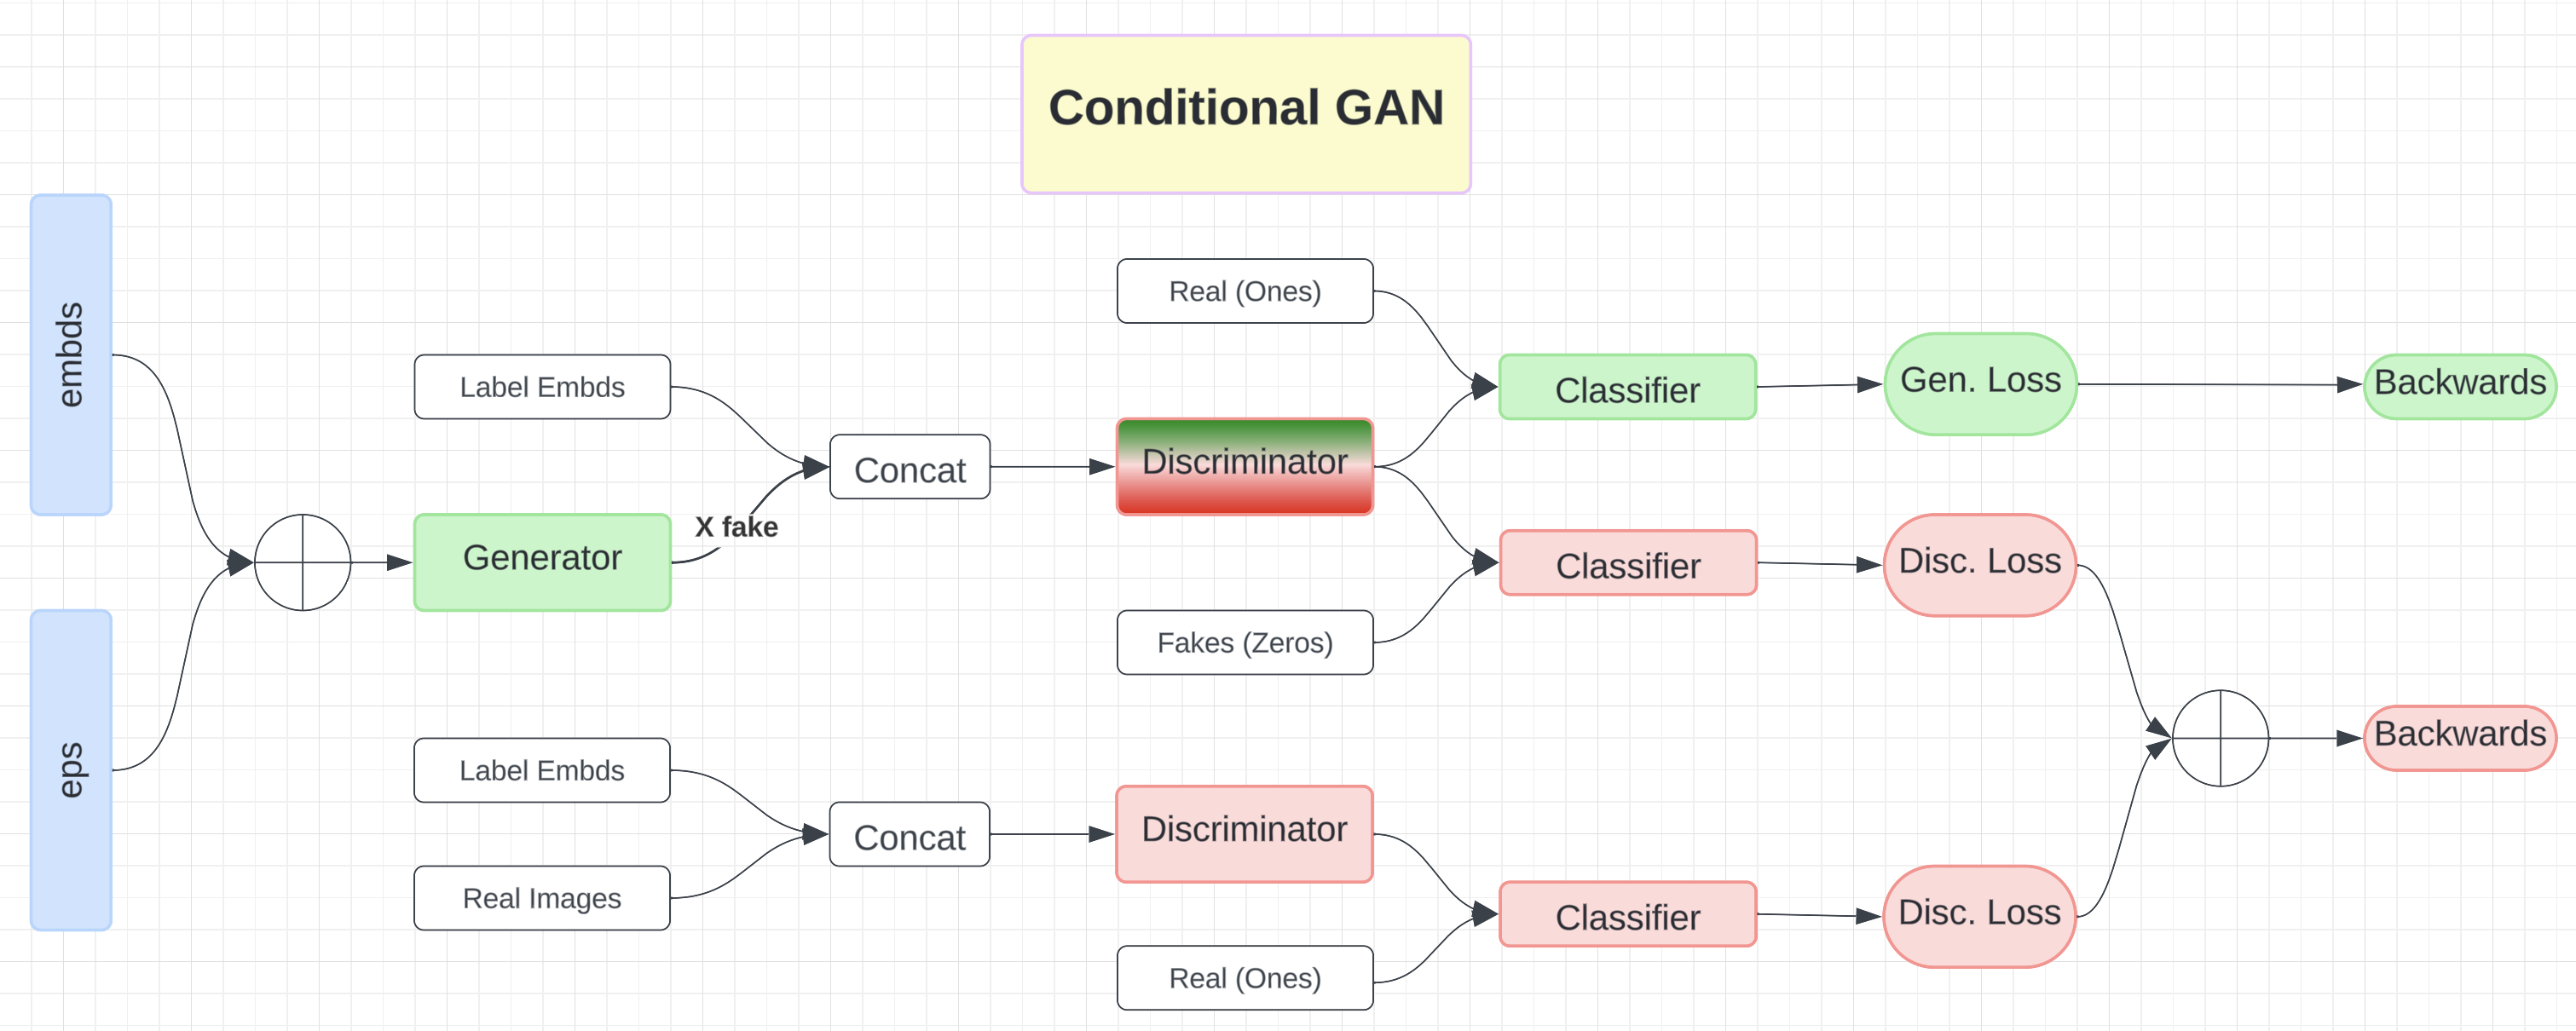

In [24]:
def train_step(model: nn.Module, trainloader: DataLoader, device: torch.device, 
               DG_TRAIN_RATIO:int, metric: callable=None):
    
    mean_g_loss, mean_dfake_loss, mean_dreal_loss = .0, .0, .0
    for real_imgs, labels in tqdm(trainloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # labels for real&fake images
        ones = torch.ones_like(labels).unsqueeze(dim=-1).float()
        zeros = torch.zeros_like(labels).unsqueeze(dim=-1).float()
        
        for _ in range(DG_TRAIN_RATIO):
            # setting grads to 0 after last generator backprop
            model.d_optimizer.zero_grad()
            
            # generated images conditioned on labels
            fake_imgs = model.generator(labels)
            
            # discriminator output based on fake&real images
            d_fake = model.discriminator(fake_imgs.detach(), labels)
            d_real = model.discriminator(real_imgs, labels)
            
            # discriminator loss using real real^fake labels
            d_fake_loss = model.d_loss(d_fake, zeros)
            d_real_loss = model.d_loss(d_real, ones)
            d_total_loss = (d_fake_loss + d_real_loss)/2 
            
            # discriminator backpropagation
            d_total_loss.backward()
            model.d_optimizer.step()

        mean_dfake_loss += d_fake_loss.item()
        mean_dreal_loss += d_real_loss.item()
        
        # generator backpropagation        
        model.g_optimizer.zero_grad()
        # print(fake_imgs.shape)
        d_fake = model.discriminator(fake_imgs, labels)
        g_loss = model.g_loss(d_fake, ones)
        
        mean_g_loss += g_loss.item()

        g_loss.backward()
        model.g_optimizer.step()

    n_batches = len(trainloader)
    mean_g_loss /= n_batches
    mean_dfake_loss /= n_batches
    return {"mean_g_loss":mean_g_loss,
            "mean_dfake_loss": mean_dfake_loss,
            "mean_dreal_loss": mean_dreal_loss}

In [25]:
def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device, metric: callable=None):
    
    mean_g_loss, mean_dfake_loss, mean_dreal_loss = .0, .0, .0
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            
            ones = torch.ones_like(labels).unsqueeze(dim=-1).float()
            zeros = torch.zeros_like(labels).unsqueeze(dim=-1).float()

            fake_imgs = model.generator(labels)
            d_fake = model.discriminator(fake_imgs, labels)
            
            d_real = model.discriminator(real_imgs, labels)
            mean_g_loss += model.g_loss(d_fake, ones).item()
            mean_dfake_loss += model.d_loss(d_fake, zeros).item()
            mean_dreal_loss += model.d_loss(d_real, ones).item()
            
        n_batches = len(testloader)
        mean_g_loss /= n_batches
        mean_dfake_loss /= n_batches 
        mean_dreal_loss /= n_batches
        
    return {"mean_g_loss":mean_g_loss,
            "mean_dfake_loss": mean_dfake_loss,
            "mean_dreal_loss": mean_dreal_loss}

In [26]:
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, DG_TRAIN_RATIO: int, metric: callable=None):
    model = model.to(device)
    for epoch in range(EPOCHS):
        print(f"Epoch ----------> {epoch+1}/{EPOCHS} | Trainig")
        train_results = train_step(model, trainloader, device, DG_TRAIN_RATIO)
        print(f"Generator Loss: {train_results['mean_g_loss']:.4f}")
        print(f"Disc. Fake Loss: {train_results['mean_dfake_loss']:.4f}")
        print(f"Disc. Real Loss: {train_results['mean_dreal_loss']:.4f}")
        
        print(" Testing")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: {test_results['mean_g_loss']:.4f}")
        print(f"Disc. Fake Loss: {test_results['mean_dfake_loss']:.4f}")
        print(f"Disc. Real Loss: {test_results['mean_dreal_loss']:.4f}")
        

        rand_labels = torch.randint(0, 10, (8,)).to(device)
        gen_imgs = model(rand_labels).to('cpu')
        show_imgs(gen_imgs, rand_labels.to('cpu'))

In [ ]:
EPOCHS = 3
LATENT_DIM = 100
DG_TRAIN_RATIO = 5

device = 'xpu' if ipex.xpu.is_available() else 'cpu'

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

g_loss = nn.BCELoss()
d_loss = nn.BCELoss()

cgan = CGAN(generator, discriminator)
cgan.compile(g_optimizer, g_loss, 
             d_optimizer, d_loss)

train(cgan, trainloader, testloader, device, EPOCHS, DG_TRAIN_RATIO)

### Saving the Model

In [20]:
from pathlib import Path
MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "cifar10_cwgan_gp.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
torch.save(cgan.state_dict(), MODEL_SAVE_PATH)